
# RNN Dead Layer Fit Project: Performance on real data
## MC2 Fixed DLF=1, Quantile Regression Loss on DLF Label


## Import general packages

In [1]:
#check env
import os
print (os.environ['CONDA_DEFAULT_ENV'])

/unix/legend/abi/ML_DL/MLenv


In [2]:
#General
import sys
import json
import yaml
import pandas as pd

#RNN imports
import numpy as np
import os
import argparse
import time
import math
import random
import torch.nn as nn
import torch.optim as optim
from torch.nn.parameter import Parameter
from torch.nn import init
import torch.nn.functional as F
import torch
import torch.utils.data as data_utils
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import gzip
import pickle
import numpy as np
from torch.autograd import Variable
from scipy import sparse
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import torchsnooper #problem installing: !pip install torchsnooper --user #this worked for installing torchsnooper
import h5py
import re
from tqdm import tqdm
from torch.cuda.amp import autocast

torch.cuda.empty_cache()

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# DEVICE = torch.device("cuda:0")
print(DEVICE)
torch.cuda.is_available()

/unix/legend/abi/ML_DL/MLenv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda:0


True

In [3]:
from src.data import *
from src.RNN import *
from src.training import *
from src.misc import *

## Get relevant paths

In [4]:
# Data paths:
CodePath = os.path.dirname(os.path.abspath("__file__"))
MC_PATH = CodePath+"/data/V05268A_data/training_data_V05268A_5000randomFCCDs_randomDLFs/"
MC_PATH_FCCDonly = CodePath+"/data/V05268A_data/training_data_V05268A_5000randomFCCDs_DLF1/"

DATA_PATH = CodePath+"/data/V05268A_data/experimental_data_V05268A.h5"
MCBESTFIT_FOLDER = CodePath+"/data/V05268A_data/MCBestFit_data_V05268A_FCCD0.97mm/"

# --------------------------------------------------------------
# COMPARE RNNS
# --------------------------------------------------------------

In [5]:
maxFCCDdiff_list = ["NA", 0.5, 0.25, 0.1, 0.05, 0.01]
NUM_EPOCHS_list = [20,20,20,20,20,20]
# NUM_EPOCHS_list = [30,30,30,30,30,30]
compareRNNs(maxFCCDdiff_list,NUM_EPOCHS_list,LEARNING_RATE = 0.005, dataset_size = 10000, RNN_ID_start="RNN_MC2DLF1")
#use: https://quicklatex.com/ to view latex table

Evaluated on restricted test dataset
╔════════════════════════════╦═════════════════╦════════════════╦════════════════╗
║ Max($\Delta_{FCCD}$) /mm   ║   Accuracy FCCD ║   Accuracy DLF ║   roc auc FCCD ║
╠════════════════════════════╬═════════════════╬════════════════╬════════════════╣
║ NA                         ║           0.995 ║          0.973 ║          1     ║
║ 0.5                        ║           0.988 ║          0.987 ║          0.999 ║
║ 0.25                       ║           0.986 ║          0.981 ║          0.998 ║
║ 0.1                        ║           0.939 ║          0.984 ║          0.995 ║
║ 0.05                       ║           0.939 ║          0.98  ║          0.992 ║
║ 0.01                       ║           0.611 ║          0.982 ║          0.679 ║
╚════════════════════════════╩═════════════════╩════════════════╩════════════════╝
\begin{tabular}{lrrr}
\hline
 Max($\Delta_{FCCD}$) /mm   &   Accuracy FCCD &   Accuracy DLF &   roc auc FCCD \\
\hline
 NA           

## Compare attention scores

In [6]:

def compare_attention(maxFCCDdiff_list, NUM_EPOCHS_list, test_loader, LEARNING_RATE = 0.005, dataset_size = 10000):
    
    fig, axs = plt.subplots(nrows=len(maxFCCDdiff_list)+1, sharex=True, figsize=(8.27, 11.69)) #, figsize=(8,6))
    binwidth = 0.5 #keV
    bins = np.arange(5,450+binwidth,binwidth)
    bins_centres = np.delete(bins+binwidth/2,-1)
    average_attention_list = []
    for ind, maxFCCDdiff in enumerate(maxFCCDdiff_list):
        NUM_EPOCHS = NUM_EPOCHS_list[ind]
        RNN_ID_start = "RNN_MC2DLF1"
        if maxFCCDdiff == "NA":
            RNN_ID =RNN_ID_start+"_"+str(NUM_EPOCHS)+"epochs_LR"+str(LEARNING_RATE)+"_fulldataset_"+str(dataset_size)+"trials"
        else:
            RNN_ID =RNN_ID_start+"_"+str(NUM_EPOCHS)+"epochs_LR"+str(LEARNING_RATE)+"_maxFCCDdiff"+str(maxFCCDdiff)+"mm_"+str(dataset_size)+"trials"
        df = pd.read_csv(CodePath+"/saved_models/"+RNN_ID+"/average_attention_hist.csv")
        average_attention = df.average_attention
        average_attention_list.append(average_attention)

        axs[ind].plot(bins_centres, average_attention, label = "maxFCCDdiff: "+str(maxFCCDdiff)+" mm")
        axs[ind].set_ylabel("Attention")
        axs[ind].set_yscale("log")
        axs[ind].set_xlim(0,450)
        axs[ind].legend(loc="lower right", fontsize=8)
        axs[ind].grid()
        axs[ind].minorticks_on()
        
    #get random spectra to plot:
    test_spectrum_diff, test_FCCDLabel, test_DLFLabel, test_extras, test_spectrum = next(iter(test_loader))
    test_spectrum = test_spectrum[1].numpy()
    axs[-1].plot(bins_centres, test_spectrum, color="red", label="Example Spectrum")
    axs[-1].legend(loc="lower right", fontsize=8)
    axs[-1].set_xlim(0,450)
    axs[-1].set_ylabel("Spectrum")
    axs[-1].set_yscale("log")
    axs[-1].set_xlabel("Energy / keV")
    axs[-1].set_xlim(0,450)
    axs[-1].grid()
    axs[-1].minorticks_on()
    # plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)

    
    


In [11]:
#load full dataset - just need a spectrum for the attention plot
dataset_size = 10000 #10000
BATCH_SIZE = 4 
train_loader, test_loader, dataset = load_data(BATCH_SIZE, size=dataset_size, path_MC2 = MC_PATH_FCCDonly)

100%|███████████████████████████████████████████████████████████████████████████████████████████| 4908/4908 [00:26<00:00, 184.51it/s]

(4908, 890)


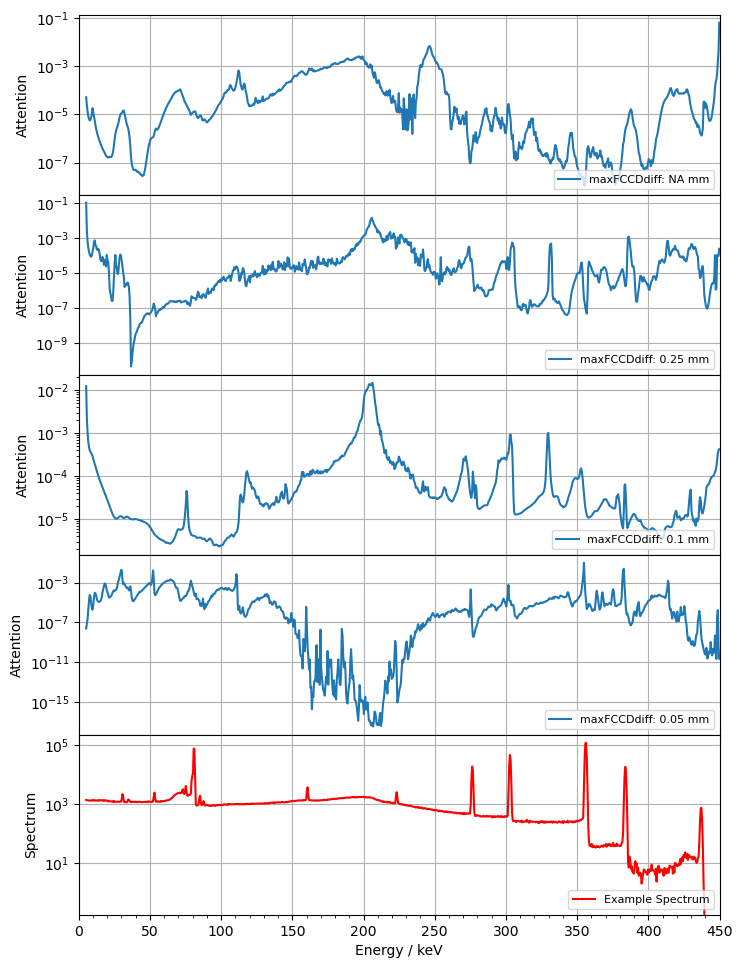

In [12]:
# maxFCCDdiff_list = ["NA", 0.5, 0.25, 0.1, 0.05, 0.01]
# NUM_EPOCHS_list = [20,20,20,20,20,20]
maxFCCDdiff_list = ["NA", 0.25, 0.1, 0.05]
NUM_EPOCHS_list = [20,20,20,20]

compare_attention(maxFCCDdiff_list, NUM_EPOCHS_list, test_loader)

# --------------------------------------------------------------
# FEED IN DATA
# --------------------------------------------------------------

In [13]:
# Load RNN - 0.05mm restriction
NUM_EPOCHS = 20 #can try increasing
LEARNING_RATE = 0.005 #0.01 #try modifying learning rate #0.001 too low for 30 epochs, 0.01 may be too high
dataset_size = 10000 #10000
maxFCCDdiff = 0.05
maxDLFdiff = 1.0 #i.e. no restriction
RNN_ID ="RNN_MC2DLF1_"+str(NUM_EPOCHS)+"epochs_LR"+str(LEARNING_RATE)+"_maxFCCDdiff"+str(maxFCCDdiff)+"mm_"+str(dataset_size)+"trials"

In [14]:
#load full dataset
BATCH_SIZE = 4 
restrict_dict = {"maxFCCDdiff": maxFCCDdiff, "maxDLFdiff": maxDLFdiff}
train_loader, test_loader, dataset = load_data(BATCH_SIZE, restrict_dataset=True, restrict_dict = restrict_dict, 
                                               size=dataset_size, path_MC2 = MC_PATH_FCCDonly)

100%|███████████████████████████████████████████████████████████████████████████████████████████| 4908/4908 [00:25<00:00, 194.10it/s]


(4908, 890)


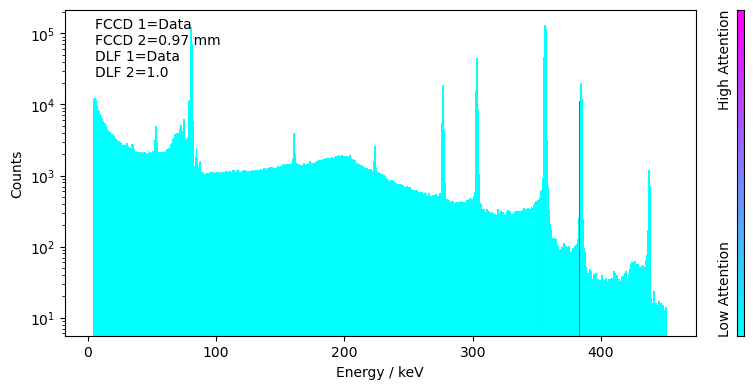

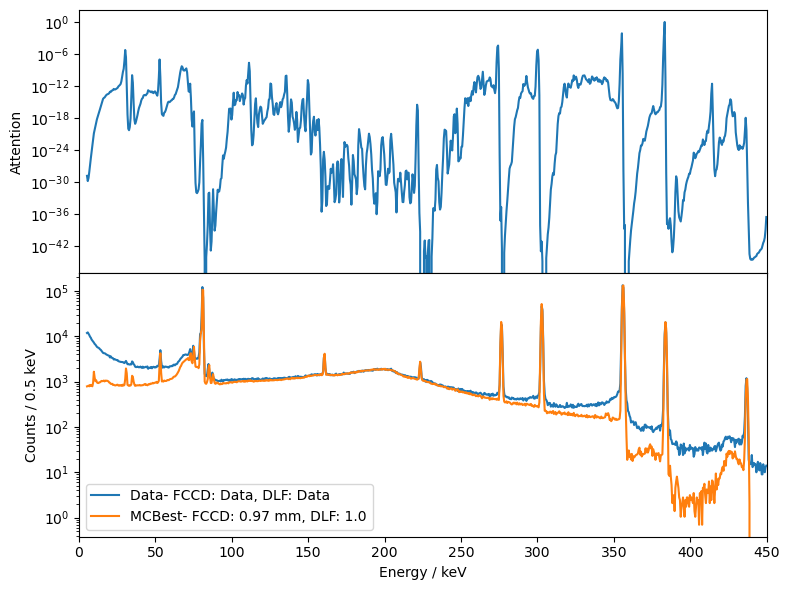

In [15]:
#load 2 data-MCBest
CodePath = os.path.dirname(os.path.abspath("__file__"))
DATA_PATH = CodePath+"/data/V05268A_data/experimental_data_V05268A.h5" #change DLF to 1
MCBESTFIT_PATH = CodePath+"/data/V05268A_data/MCBestFit_data_V05268A_FCCD0.97mm/V05268A-ba_HS4-top-0r-78z_g_l_FCCD0.97mm_DLF1.0_fracFCCDbore0.5.h5"
spectrum_diff, counts1, counts2 = load_two_spectra(DATA_PATH, MCBESTFIT_PATH, dataset, MC1=False, MC2=True)
spectrum1, spectrum2 = counts1, counts2
labels = {"FCCD1": "Data", "FCCD2": "0.97 mm", "DLF1": "Data", "DLF2": "1.0", "spectrum1": "Data", "spectrum2":"MCBest"}
outputs = test_RNN_spectrumdiff(RNN_ID, spectrum_diff, spectrum1, spectrum2, labels, save_results=True)
#outputs = FCCD, DLF-10, DFLF-50, DLF-90

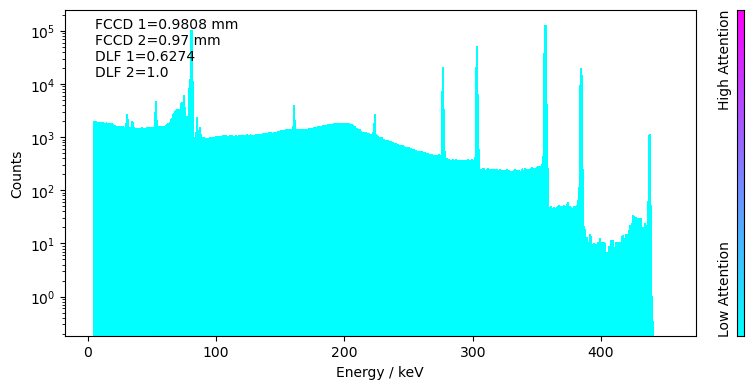

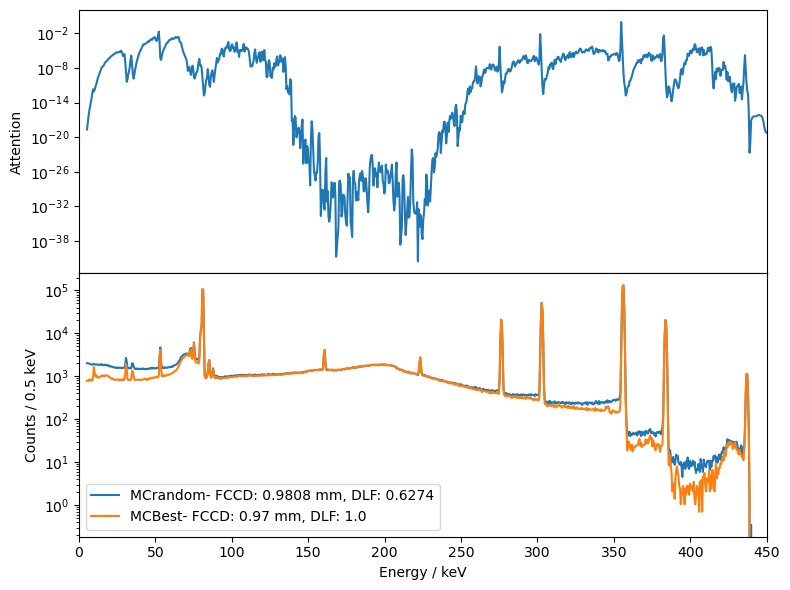

In [20]:
#load 2 random spectra
CodePath = os.path.dirname(os.path.abspath("__file__"))
MCBESTFIT_PATH = CodePath+"/data/V05268A_data/MCBestFit_data_V05268A_FCCD0.97mm/V05268A-ba_HS4-top-0r-78z_g_l_FCCD0.97mm_DLF1.0_fracFCCDbore0.5.h5"
MCRANDOM_PATH = CodePath+"/data/V05268A_data/training_data_V05268A_5000randomFCCDs_DLF1/V05268A-ba_HS4-top-0r-78z_g_l_FCCD1.7572mm_DLF1.0_fracFCCDbore0.5.h5"
# MCRANDOM2_PATH = CodePath+"/data/V05268A_data/training_data_V05268A_5000randomFCCDs_randomDLFs/V05268A-ba_HS4-top-0r-78z_g_l_FCCD1.6376mm_DLF0.4082_fracFCCDbore0.5.h5"
MCRANDOM3_PATH = CodePath+"/data/V05268A_data/training_data_V05268A_5000randomFCCDs_randomDLFs/V05268A-ba_HS4-top-0r-78z_g_l_FCCD0.9808mm_DLF0.6274_fracFCCDbore0.5.h5"

spectrum_diff, counts1, counts2 = load_two_spectra(MCRANDOM3_PATH, MCBESTFIT_PATH, dataset, MC1=True, MC2=True)
spectrum1, spectrum2 = counts1, counts2
# labels = {"FCCD1": "1.6376 mm", "FCCD2": "0.97 mm", "DLF1": "0.4082", "DLF2": "1.0", "spectrum1": "MCrandom", "spectrum2":"MCBest"}
labels = {"FCCD1": "0.9808 mm", "FCCD2": "0.97 mm", "DLF1": "0.6274", "DLF2": "1.0", "spectrum1": "MCrandom", "spectrum2":"MCBest"}
outputs = test_RNN_spectrumdiff(RNN_ID, spectrum_diff, spectrum1, spectrum2, labels)
#outputs = FCCD, DLF-10, DFLF-50, DLF-90

## FCCD output hist

In [21]:
def plot_FCCD_pdf(RNN_ID):
    "plot the pdf of RNN FCCD output on test training data, with quantiles"
    
    #open hist
    CodePath = os.path.dirname(os.path.abspath("__file__"))
    df = pd.read_csv(CodePath+"/saved_models/"+RNN_ID+"/FCCD_test_classification_hist.csv")
    bins_centres, counts0, counts1 = df.bins_centres, df.counts0, df.counts1
    bins = np.linspace(0,1,201) 
    
    #compute 10% and 90% quantiles for exclusion region
    pdf1_q10 = find_hist_quantile(counts1, bins, 0.1)
    pdf0_q90 = find_hist_quantile(counts0, bins, 0.9)
    
    #plot
    fig, ax = plt.subplots()
    plt.step(bins_centres, counts0/sum(counts0), linestyle='-',linewidth=1, label = "FCCD truth label = 0", color="blue")
    plt.step(bins_centres, counts1/sum(counts1), linestyle='-',linewidth=1, label = "FCCD truth label = 1", color="orange")
    plt.vlines(pdf1_q10, min(counts1), 1/2, ls="-.", color="orange")
    plt.vlines(pdf0_q90, min(counts1), 1/2, ls="-.", color="blue")
    # plt.Rectangle( [pdf0_q90,min(counts1)], pdf1_q10-pdf0_q90, 1/2, color="grey") #, angle=0.0 ÷, rotation_point='xy')
    plt.legend(loc="upper left", title="RNN output region of uncertainty: "+ str(pdf0_q90)+" - "+str(pdf1_q10), title_fontsize=9, fontsize=9)
    plt.xlabel("RNN Output FCCD")
    plt.ylabel("PDF")
    plt.ylim(0.5*10**(-3), 2)
    plt.yscale("log")
    plt.savefig(CodePath+"/saved_models/"+RNN_ID+"/plots/FCCD_test_classification_pdf.png")
    
    return pdf1_q10, pdf0_q90


In [22]:
NUM_EPOCHS = 20 #can try increasing
LEARNING_RATE = 0.005 #0.01 #try modifying learning rate #0.001 too low for 30 epochs, 0.01 may be too high
dataset_size = 10000 #10000
maxFCCDdiff = 0.05
maxDLFdiff = 1.0 #i.e. no restriction
RNN_ID ="RNN_MC2DLF1_"+str(NUM_EPOCHS)+"epochs_LR"+str(LEARNING_RATE)+"_maxFCCDdiff"+str(maxFCCDdiff)+"mm_"+str(dataset_size)+"trials"
# RNN_ID ="RNN_MC2DLF1_"+str(NUM_EPOCHS)+"epochs_LR"+str(LEARNING_RATE)+"_fulldataset_"+str(dataset_size)+"trials"


0.89
0.53


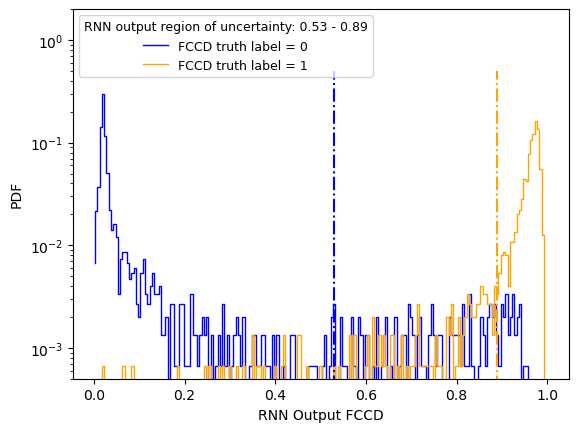

In [23]:
# find 90% quantile
pdf1_q10, pdf0_q90 = plot_FCCD_pdf(RNN_ID)

## Scanning Study

[0.27, 0.32, 0.37, 0.42, 0.47, 0.52, 0.57, 0.62, 0.67, 0.72, 0.77, 0.82, 0.87, 0.92, 0.97, 1.02, 1.07, 1.12, 1.17, 1.22, 1.27, 1.32, 1.37, 1.42, 1.47, 1.52, 1.57, 1.62]


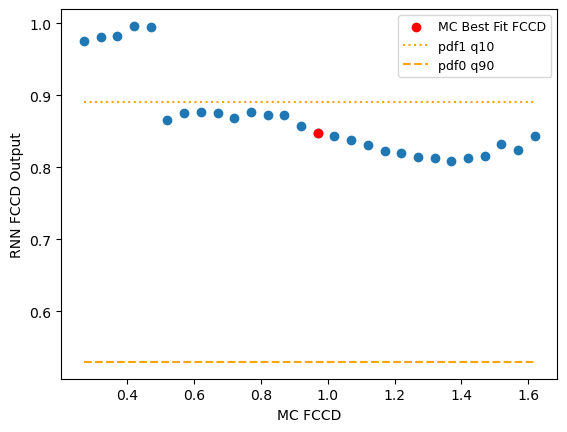

In [24]:

CodePath = os.path.dirname(os.path.abspath("__file__"))
FCCD_list = list(np.around(np.arange(0.97-0.7, 0.97+0.7, 0.05),2))
print(FCCD_list)

RNN_FCCD_outputs = []
for ind, FCCD in enumerate(FCCD_list):
    MC_PATH = CodePath+"/data/V05268A_data/training_data_V05268A_5000randomFCCDs_DLF1/V05268A-ba_HS4-top-0r-78z_g_l_FCCD"+str(round(FCCD,2))+"mm_DLF1.0_fracFCCDbore0.5.h5"
    spectrum_diff, counts1, counts2 = load_two_spectra(DATA_PATH, MC_PATH, dataset, MC1=False, MC2=True)
    spectrum1, spectrum2 = counts1, counts2
    labels = {"FCCD1": "Data", "FCCD2": str(round(FCCD,2))+"mm", "DLF1": "Data", "DLF2": "1.0", "spectrum1": "Data", "spectrum2":"MC"}
    outputs = test_RNN_spectrumdiff(RNN_ID, spectrum_diff, spectrum1, spectrum2, labels, save_results=False, plot_results=False)
    #outputs = FCCD, DLF-10, DFLF-50, DLF-90
    RNN_FCCD_outputs.append(outputs[0][0])

plt.figure()
plt.scatter(FCCD_list, RNN_FCCD_outputs)
plt.scatter(0.97, RNN_FCCD_outputs[FCCD_list.index(0.97)], label="MC Best Fit FCCD", color = "red")
plt.xlabel("MC FCCD")
plt.ylabel("RNN FCCD Output")
plt.hlines(pdf1_q10, min(FCCD_list), max(FCCD_list), label="pdf1 q10", color = "orange", ls="dotted")
plt.hlines(pdf0_q90, min(FCCD_list), max(FCCD_list), label="pdf0 q90", color ="orange", ls="dashed")
plt.legend(fontsize=9)

## To do/ Questions


- Problem: quantile outputs on data-MCBest not in right order: -> SOLVED
    - related problem: why does rnn output vary when rerunning?
    - check errors by doing MCrandom-MCBest and see if output makes sense
       -if DLF quantiles dont make sense, can change RNN output on DLF to be a prediction (with MSE error)
    - scaler prpblem: only need one scaler, could even try no scaler


To do:
- try different normalisations: by total hist amount, but x 10^3 to ensure large enough for RNN -> this shouldnt matter given we use a scaler
- try different RNN inputs: 
    - divide: already tried, I dont think this works
    -log difference: could be worth trying but not a priority
- scanning study: try variations about best fit FCCD and read results
- try 3 detectors total to get a table of results
- discuss attention score/interpretability, compton edge -> future direction of study